# Building the default synaptic map

In [1]:
# Create an empty list to store the cell types
cell_type_list <- list()

# List all the .txt files in the current directory
txt_files <- list.files(pattern = "*.txt")

# Loop through each file and process it
for (file in txt_files) {
    # Read the contents of the file
    contents <- readLines(file)
    
    # Split the contents by commas and convert them into a list of barcodes
    barcodes <- unlist(strsplit(contents, ","))
    
    # Add the barcodes to the list with the file name (without .txt extension) as the key
    cell_type_list[[gsub(".txt", "", file)]] <- barcodes
}

# Now cell_type_list contains each cell type as a list of barcodes


In [ ]:
# Load the data if not already loaded
# cell_type_list <- readRDS("cell_type_list.rds")
# syn_connections <- readRDS("syn.connections.rds")

# Create a mapping from each cell barcode to its cell type.
barcode_to_type <- unlist(lapply(names(cell_type_list), function(cell_type) {
  setNames(rep(cell_type, length(cell_type_list[[cell_type]])), cell_type_list[[cell_type]])
}))

# Add the pre_type and post_type columns using within()
syn_connections <- within(syn_connections, {
  pre_type <- barcode_to_type[as.character(pre_pt_root_id)]
  post_type <- barcode_to_type[as.character(post_pt_root_id)]
})

# Check that the new columns are present (optional)
print(head(syn_connections[c("pre_pt_root_id", "pre_type", "post_pt_root_id", "post_type")]))

# Warn if any barcodes did not match a cell type.
if (any(is.na(syn_connections$pre_type)) || any(is.na(syn_connections$post_type))) {
  warning("Some cell barcodes in syn_connections did not match any cell type in cell_type_list.")
}

# Now aggregate the synapse counts by cell type.
syn_agg <- aggregate(syn_count ~ pre_type + post_type, data = syn_connections, FUN = sum)

# Optionally, save the aggregated object:
# saveRDS(syn_agg, "syn_agg.rds")

# Print the aggregated data frame to view the results
print(syn_agg)



In [4]:
syn_agg <- readRDS('syn_agg.rds')

In [4]:
head(syn_agg)

pre_type post_type syn_count
1 AL-PN    AL-PN     64548    
2 CLKN     AL-PN        42    
3 DAN      AL-PN      1120    
4 EB-RN    AL-PN         1    
5 JON      AL-PN        25    
6 KCab     AL-PN      1184

# Imbedding the PSEA result

In [1]:
df_long <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/df_long_with_updated_clusters.csv")

In [2]:
options(repr.plot.res = 500)   # resolution in DPI

# Make background white
par(bg = "white")


In [80]:
library(dplyr)

# Define the finalized GO terms
final_go_terms <- c(#"GO:0007269"   # neurotransmitter secretion
                    "GO:0099536"  # synaptic signaling
                    ,"GO:0051588"  # regulation of neurotransmitter transport
                    ,"GO:0006836"  # neurotransmitter loading into synaptic vesicle
                    ,"GO:0023061"  # synaptic vesicle priming 
                    #,"GO:0050808"  # synapse organization
                    #,"GO:0048167"  # regulation of synaptic plasticity
                    ,"GO:0099003"  # vesicle-mediated transport in synapse
                    #,"GO:0045202" # synapse
                    ,"GO:0098960"  # postsynaptic neurotransmitter receptor activity 
                    #,"GO:0006836"  # neurotransmitter transport 
                    ,"GO:0008088"  # axo-dendritic transport
                    #,"GO:0098793"  # presynapse
                    #,"GO:0098794"  # postsynapse
                   )
# Read the data
df_long <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/df_long_with_updated_clusters.csv")
df_long <- df_long[df_long$Set.N > 3,]

# Filter for rows containing one of the finalized GO terms
df_filtered <- df_long %>%
  filter(GO %in% final_go_terms)

# Bin the time point information from the "Value" column into 6 ranges:
# 0-4, 4-8, 8-12, 12-16, 16-20, and 20-24.
df_filtered <- df_filtered %>%
  mutate(Time_bin = cut(Value,
                        breaks = c(0, 4, 8, 12, 16, 20, 24),
                        labels = c("0-4", "4-8", "8-12", "12-16", "16-20", "20-24"),
                        right = FALSE,
                        include.lowest = TRUE))

# Bin the results by CellType, Condition, and Time_bin.
# Here we count the number of unique GO terms detected for each combination.
go_summary <- df_filtered %>%
  group_by(CellType, Condition, Time_bin) %>%
  summarize(detected_terms = n_distinct(GO),
            total_signals = n(),     # Total rows (if you want a raw count)
            .groups = "drop")

library(dplyr)

# Prepare final GO summary collapsed by CellType and Condition
go_collapsed <- go_summary %>%
  group_by(CellType, Condition) %>%
  summarise(detected_terms = sum(detected_terms, na.rm = TRUE), .groups = "drop")

# Initialize list to store per-condition summaries
clkn_summary_list <- list()

# Loop over each condition explicitly
for (cond in c("WTLD", "WTDD", "MTLD", "MTDD")) {
  
  # Filter GO terms and synapses relevant to this condition
  go_cond <- go_collapsed %>% filter(Condition == cond)
  syn_cond <- syn_agg %>%
    filter((pre_type == "OAN" | post_type == "OAN") & pre_type != post_type)
  
  # Join GO data for presynaptic cell
  syn_joined <- syn_cond %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # Summarize
  score_summary <- syn_joined %>%
    summarise(
      Condition = cond,
      total_raw = sum(raw_score, na.rm = TRUE),
      sum_log = sum(log10(raw_score + 1), na.rm = TRUE),
    )
  
  clkn_summary_list[[cond]] <- score_summary
}

# Combine results
clkn_summary <- bind_rows(clkn_summary_list)
print(clkn_summary)



  Condition total_raw   sum_log
1      WTLD      2087 15.693664
2      WTDD       541  8.078281
3      MTLD       983  5.908784
4      MTDD         0  0.000000


### default map

Note: 1 point is out of plotting region in sector 'AL-PN', track '1'.

Note: 1 point is out of plotting region in sector 'AL-PN', track '1'.

Note: 1 point is out of plotting region in sector 'C2', track '1'.

Note: 1 point is out of plotting region in sector 'C2', track '1'.

Note: 1 point is out of plotting region in sector 'C3', track '1'.

Note: 1 point is out of plotting region in sector 'C3', track '1'.

Note: 1 point is out of plotting region in sector 'CLKN', track '1'.

Note: 1 point is out of plotting region in sector 'CLKN', track '1'.

Note: 1 point is out of plotting region in sector 'DAN', track '1'.

Note: 1 point is out of plotting region in sector 'DAN', track '1'.

Note: 1 point is out of plotting region in sector 'dFB', track '1'.

Note: 1 point is out of plotting region in sector 'dFB', track '1'.

Note: 1 point is out of plotting region in sector 'Dm1', track '1'.

Note: 1 point is out of plotting region in sector 'Dm1', track '1'.

Note: 1 point is out of plotting

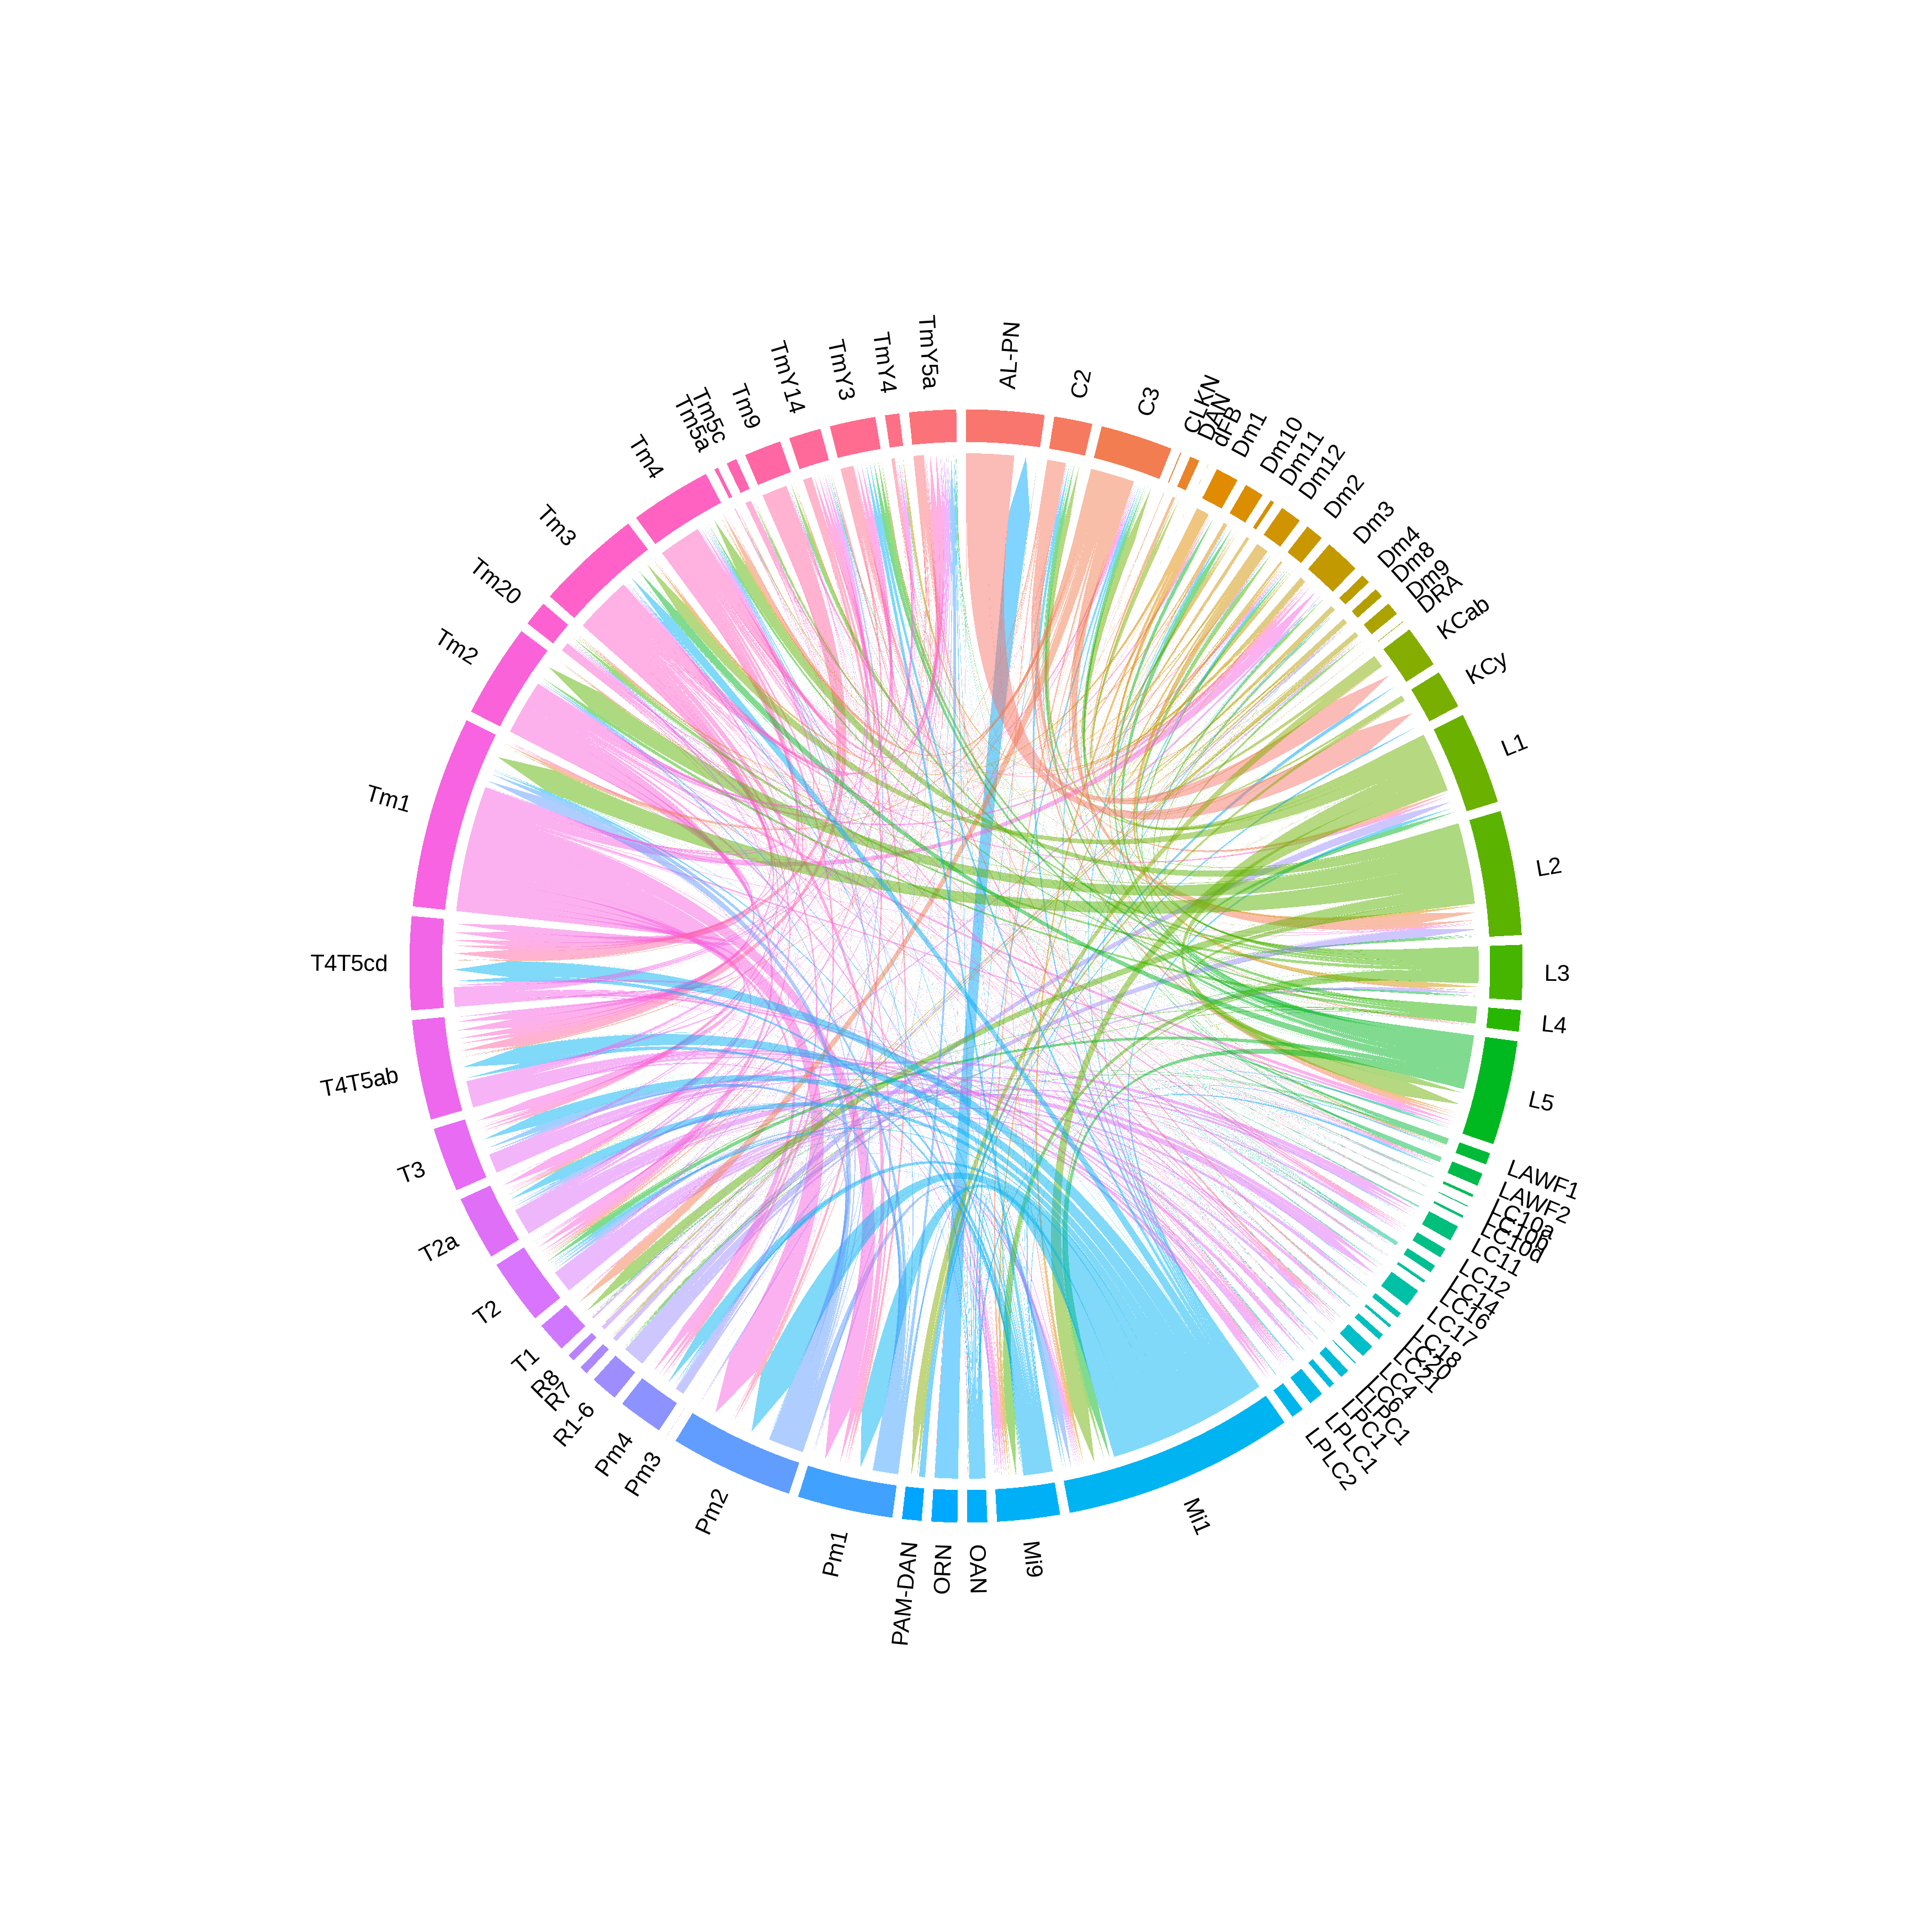

In [325]:
library(dplyr)
library(circlize)
library(RColorBrewer)
library(scales)

# Open a PDF device for a larger output (adjust as needed)
#pdf("chord_diagram_rotated.pdf", width = 12, height = 12)

# Increase margins and allow drawing outside the plot region
par(mar = c(6, 6, 6, 6), xpd = NA, bg = "white")

# Clear any previous circlize settings
circos.clear()

# Set the start degree to 90 so that the first sector is at the top
circos.par(
  start.degree = 90,            # Rotate so that the first (alphabetically "A") sector is at the top
  canvas.xlim = c(-1.5, 1.5),    # Expand canvas to avoid clipping
  canvas.ylim = c(-1.5, 1.5)
)

# Load your aggregated synaptic connections data
syn_agg <- readRDS("syn_agg.rds")

# Filter out self-directed synapses
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

# Alphabetically sort cell types
cell_types <- sort(unique(c(syn_agg_filtered$pre_type, syn_agg_filtered$post_type)))
n_colors <- length(cell_types)

# Create a hue-based palette (similar to seaborn's husl)
palette_colors <- hue_pal()(n_colors)
cell_type_colors <- setNames(palette_colors, cell_types)

# Scale link widths relative to syn_count
max_syn <- max(syn_agg_filtered$syn_count, na.rm = TRUE)
link_widths <- syn_agg_filtered$syn_count / max_syn * 5

# Create the chord diagram with sectors ordered alphabetically
chordDiagram(
  x = syn_agg_filtered[, c("pre_type", "post_type", "syn_count")],
  order = cell_types,          # Enforce alphabetical order around the circle
  grid.col = cell_type_colors,
  directional = 1,
  direction.type = c("arrows"),
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  transparency = 0.5,
  link.lwd = link_widths,
  annotationTrack = "grid",
  grid.border = NA            # Remove sector grid borders
)

# Add a custom track with black labels for each cell type
circos.trackPlotRegion(
  track.index = 1,
  bg.border = NA,
  panel.fun = function(x, y) {
    sector_name <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-5),  # Adjust this value (e.g., mm_y(2) or mm_y(3)) to move labels further out
      sector_name,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.5
    )
  }
)

# Close the PDF device
#dev.off()


## WT LD

Condition: WTLD 
Total raw interactions: 4236123 
Number of cell types: 65 
Average raw interactions per cell type: 65171.12 
Ratio (WTLD_avg/current_avg): 0.63 
Calculated dynamic gap: 0.7 


Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting region in sector 'Dm12', track '2'.

Note: 1 point is out of plotting region in sector 'Dm12', track '2'.

Note: 1 point is out of plotti

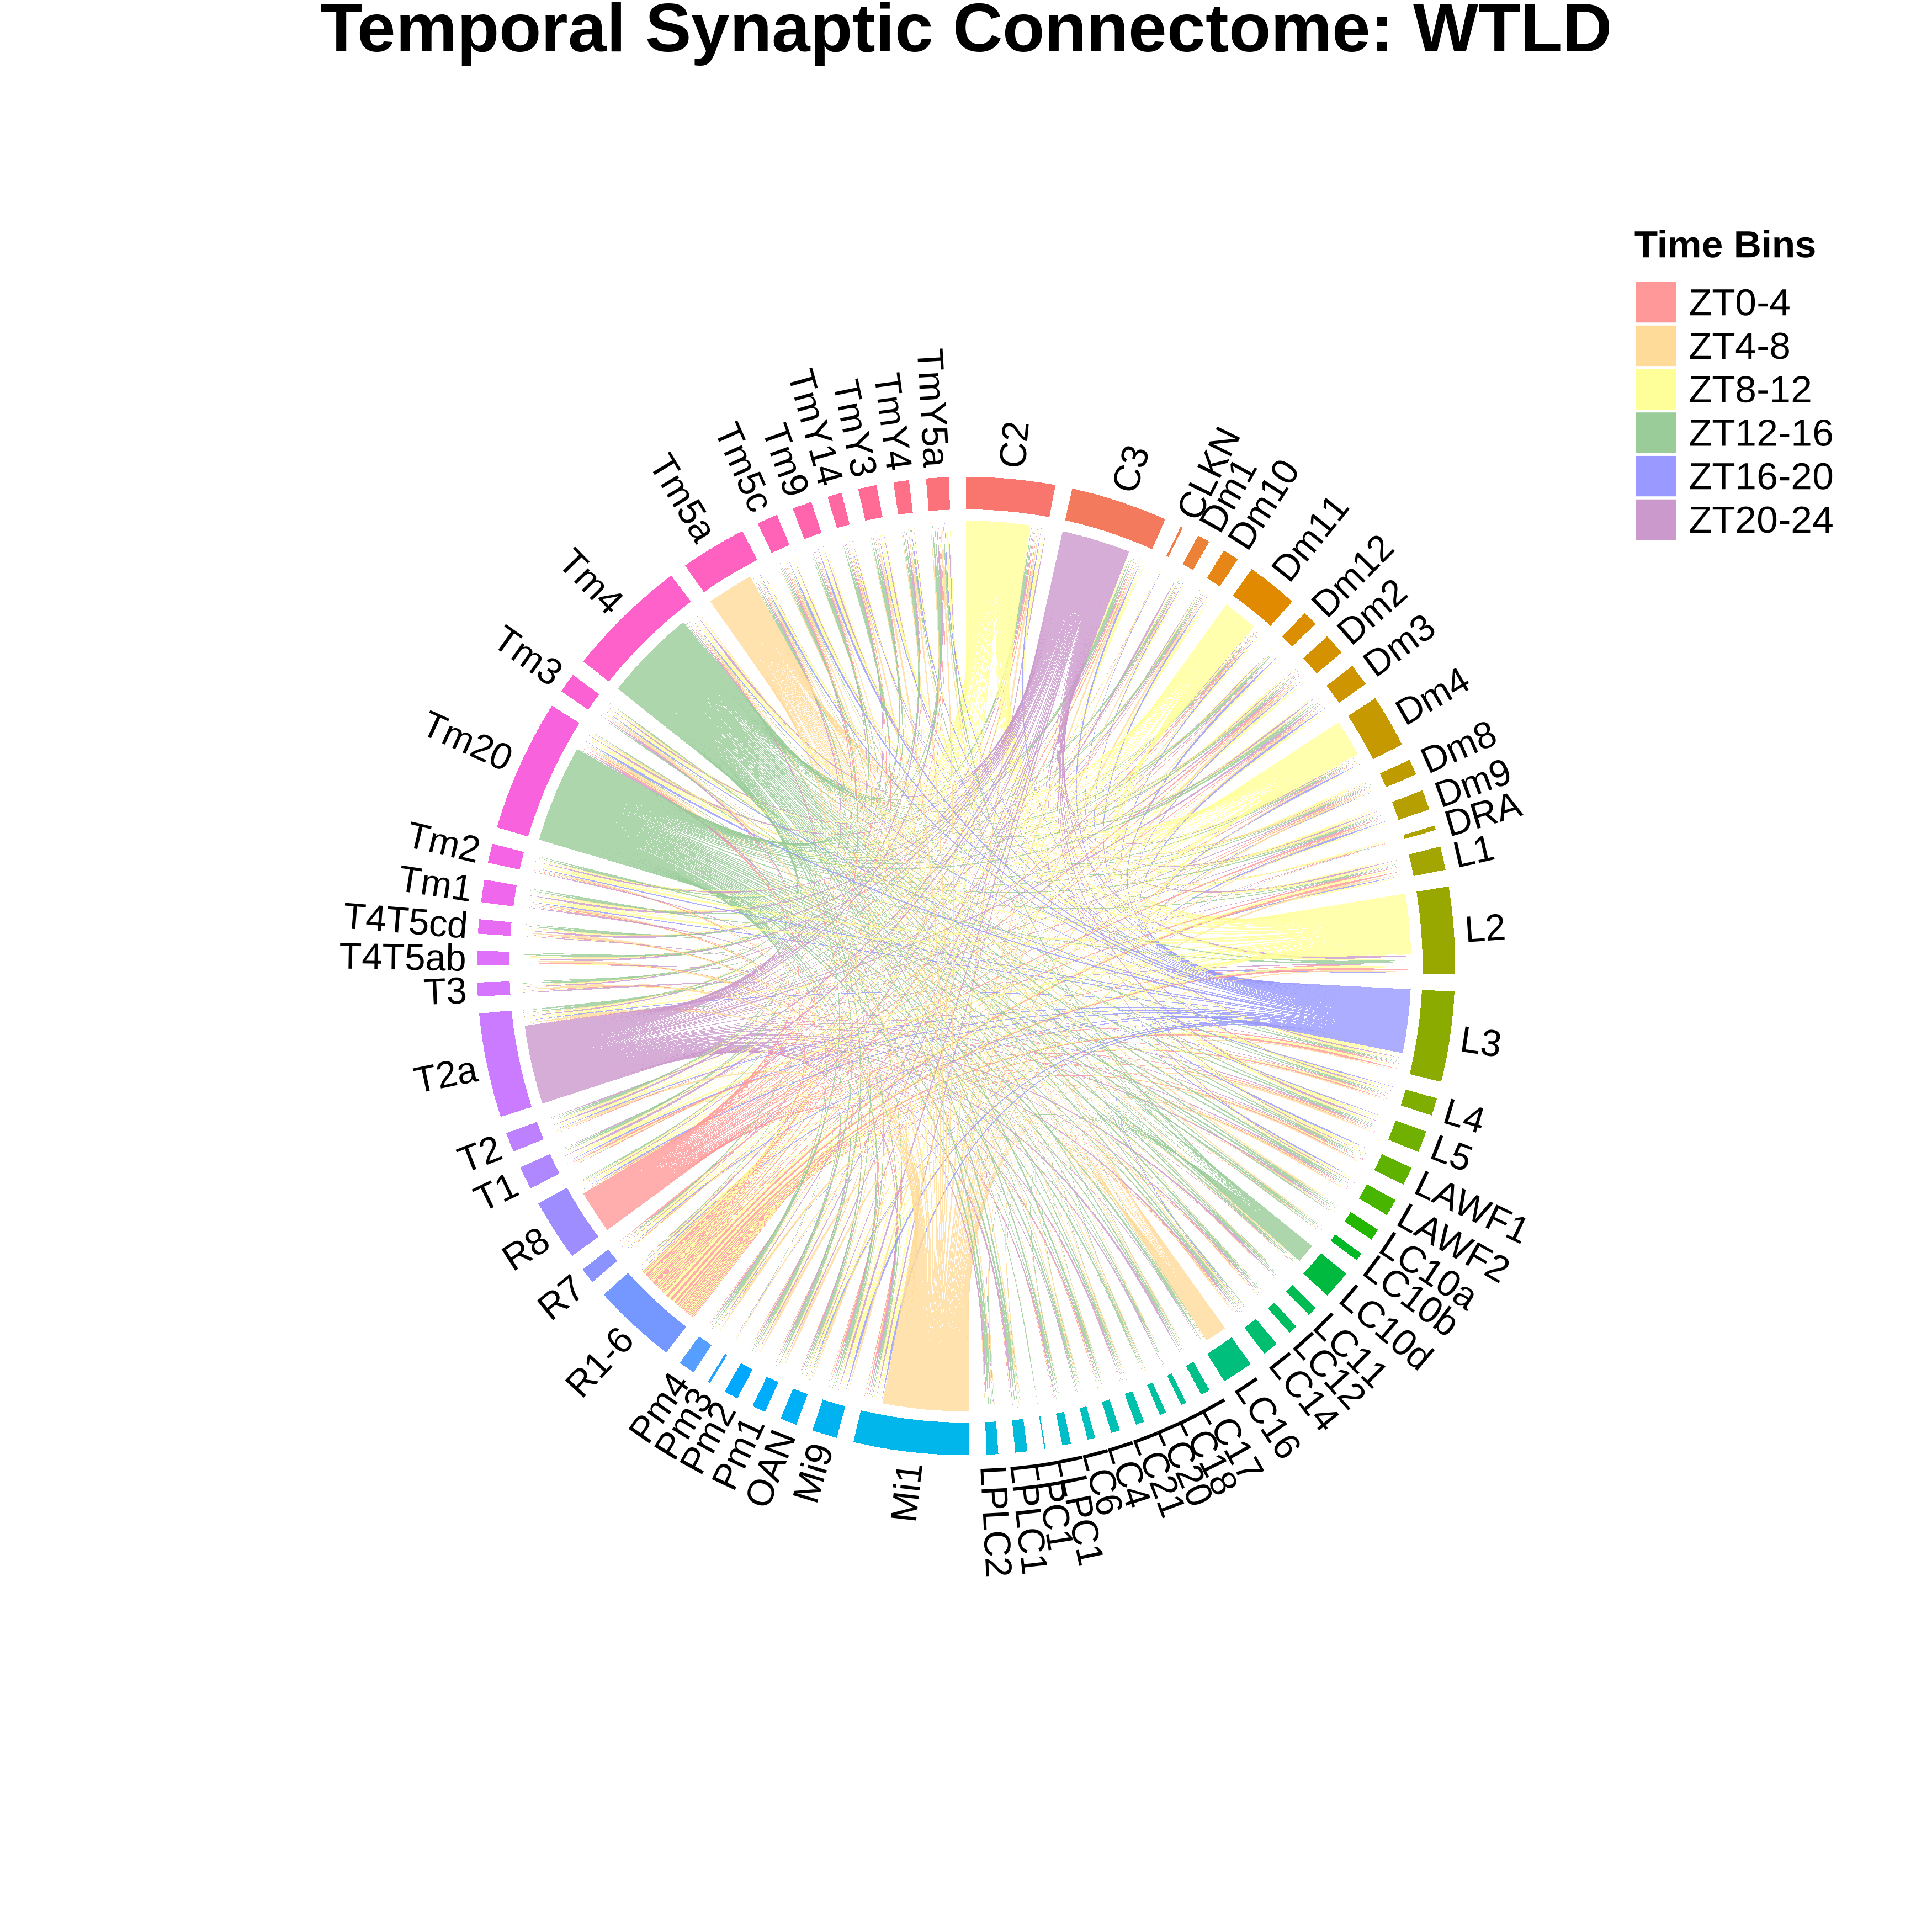

In [288]:
library(dplyr)
library(circlize)
library(RColorBrewer)
library(scales)
library(ComplexHeatmap)
library(grid)  # For unit()

# ------------------------------
# Filter out self-connections
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

par(bg = "white")

# Define time bin colors (must match Time_bin values)
time_block_colors <- c("ZT0-4" = "#ff9999", 
                       "ZT4-8" = "#ffdb99", 
                       "ZT8-12" = "#ffff99", 
                       "ZT12-16" = "#99cc99", 
                       "ZT16-20" = "#9999ff", 
                       "ZT20-24" = "#cc99cc")

# Plot one condition
cond <- "WTLD"

# Filter go_summary for current condition
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)

# Join GO term info to synapse table
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")

# Subset for current condition
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)

# Compute raw and communication score
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )

# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
current_cells <- length(unique(c(df_cond$pre_type, df_cond$post_type)))
current_avg <- total_interactions / current_cells
WTLD_avg <- 41284.74
G_min <- 1.5
alpha <- (7.49 - G_min) / log2(WTLD_avg / 1355.31)
ratio <- WTLD_avg / current_avg
dynamic_gap <- min(G_min + alpha * log2(ratio), 7.49)

# Print diagnostic info
cat("Condition:", cond, "\n")
cat("Total raw interactions:", total_interactions, "\n")
cat("Number of cell types:", current_cells, "\n")
cat("Average raw interactions per cell type:", round(current_avg, 2), "\n")
cat("Ratio (WTLD_avg/current_avg):", round(ratio, 2), "\n")
cat("Calculated dynamic gap:", round(dynamic_gap, 2), "\n")

# Assign colors to links (check for missing Time_bin)
df_cond <- df_cond %>%
  mutate(col = time_block_colors[Time_bin]) %>%
  mutate(col = ifelse(is.na(col), "#cccccc", col))  # fallback color

# Prepare for plotting
df_chord <- df_cond %>%
  rename(from = pre_type,
         to = post_type,
         value = Communication_score)

sector_names <- sort(unique(c(df_chord$from, df_chord$to)))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

# Safe link width computation
max_score <- max(df_chord$value, na.rm = TRUE)
df_chord <- df_chord %>%
  mutate(link_width = pmax(0.2, value / max_score * 5))  # ensure ≥ 0.2

# Optional manual override
 dynamic_gap <- 2

# Plot settings
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)

# Draw the chord diagram
chordDiagram(
  x = df_chord[, c("from", "to", "value")],
  order = sector_names,
  grid.col = sector_colors,
  col = df_chord$col,
  directional = 1,
  direction.type = "arrows",
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$link_width,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.1)
)

# Add labels (suppress overflow warnings)
old_warn <- getOption("warn")
options(warn = -1)

circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

options(warn = old_warn)

# Add time bin legend
lgd_bins <- Legend(
  labels = names(time_block_colors),
  legend_gp = gpar(fill = time_block_colors),
  title = "Time Bins"
)
draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.8, "npc"))

# Add plot title
title(main = paste("Temporal Synaptic Connectome:", cond), cex.main = 1.5)


## WTDD

Condition: WTDD 
Total raw interactions: 1249468 
Number of cell types: 71 
Average raw interactions per cell type: 17598.14 
Ratio (WTLD_avg/current_avg): 2.35 
Calculated dynamic gap: 3 


Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'DAN', track '2'.

Note: 1 point is out of plotting region in sector 'DAN', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotti

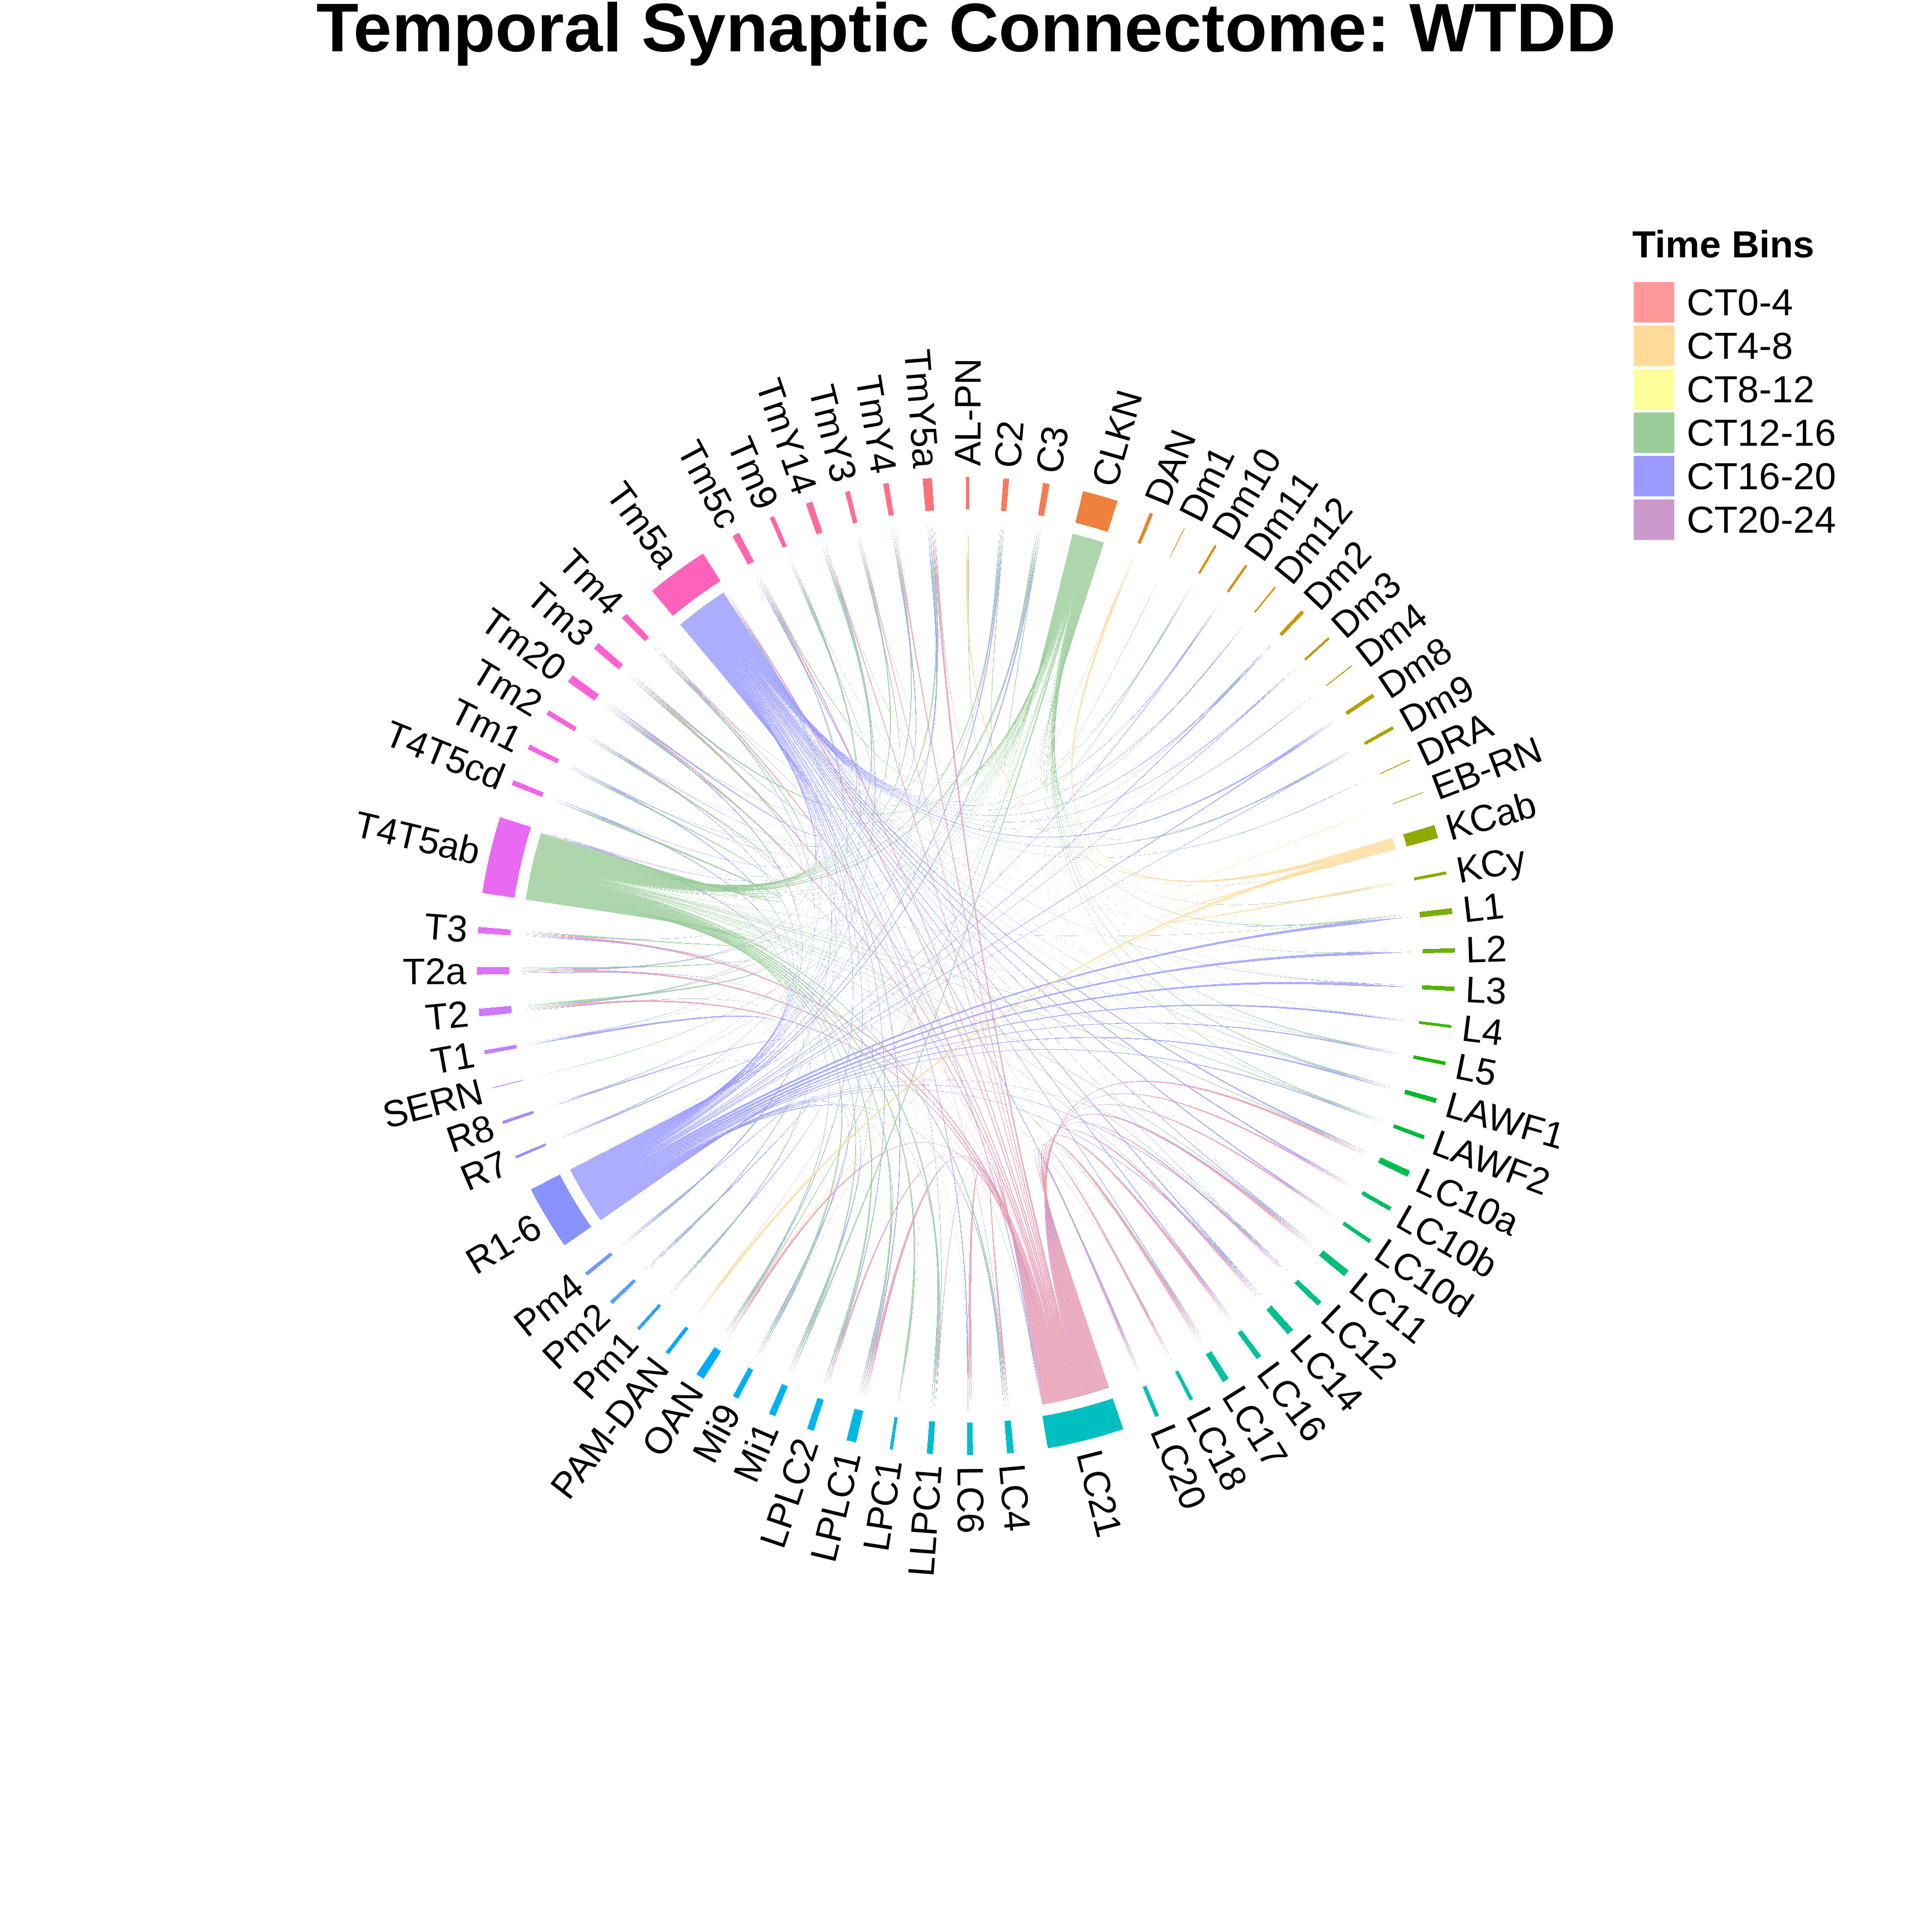

In [285]:
library(dplyr)
library(circlize)
library(RColorBrewer)
library(scales)
library(ComplexHeatmap)
library(grid)  # For unit()

# ------------------------------
# Filter out self-connections
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

par(bg = "white")

# Define time bin colors (must match Time_bin values)
time_block_colors <- c("CT0-4" = "#ff9999", 
                       "CT4-8" = "#ffdb99", 
                       "CT8-12" = "#ffff99", 
                       "CT12-16" = "#99cc99", 
                       "CT16-20" = "#9999ff", 
                       "CT20-24" = "#cc99cc")

# Plot one condition
cond <- "WTDD"

# Filter go_summary for current condition
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)

# Join GO term info to synapse table
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")

# Subset for current condition
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)

# Compute raw and communication score
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )

# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
current_cells <- length(unique(c(df_cond$pre_type, df_cond$post_type)))
current_avg <- total_interactions / current_cells
WTLD_avg <- 41284.74
G_min <- 1.5
alpha <- (7.49 - G_min) / log2(WTLD_avg / 1355.31)
ratio <- WTLD_avg / current_avg
dynamic_gap <- min(G_min + alpha * log2(ratio), 7.49)

# Print diagnostic info
cat("Condition:", cond, "\n")
cat("Total raw interactions:", total_interactions, "\n")
cat("Number of cell types:", current_cells, "\n")
cat("Average raw interactions per cell type:", round(current_avg, 2), "\n")
cat("Ratio (WTLD_avg/current_avg):", round(ratio, 2), "\n")
cat("Calculated dynamic gap:", round(dynamic_gap, 2), "\n")

# Assign colors to links (check for missing Time_bin)
df_cond <- df_cond %>%
  mutate(col = time_block_colors[Time_bin]) %>%
  mutate(col = ifelse(is.na(col), "#cccccc", col))  # fallback color

# Prepare for plotting
df_chord <- df_cond %>%
  rename(from = pre_type,
         to = post_type,
         value = Communication_score)

sector_names <- sort(unique(c(df_chord$from, df_chord$to)))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

# Safe link width computation
max_score <- max(df_chord$value, na.rm = TRUE)
df_chord <- df_chord %>%
  mutate(link_width = pmax(0.2, value / max_score * 5))  # ensure ≥ 0.2

# Optional manual override
 dynamic_gap <- 4

# Plot settings
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)

# Draw the chord diagram
chordDiagram(
  x = df_chord[, c("from", "to", "value")],
  order = sector_names,
  grid.col = sector_colors,
  col = df_chord$col,
  directional = 1,
  direction.type = "arrows",
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$link_width,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.1)
)

# Add labels (suppress overflow warnings)
old_warn <- getOption("warn")
options(warn = -1)

circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

options(warn = old_warn)

# Add time bin legend
lgd_bins <- Legend(
  labels = names(time_block_colors),
  legend_gp = gpar(fill = time_block_colors),
  title = "Time Bins"
)
draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.8, "npc"))

# Add plot title
title(main = paste("Temporal Synaptic Connectome:", cond), cex.main = 1.5)


## MT LD

Condition: MTLD 
Total raw interactions: 1673056 
Number of cell types: 56 
Average raw interactions per cell type: 29876 
Ratio (WTLD_avg/current_avg): 1.38 
Calculated dynamic gap: 2.07 


Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm1', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting region in sector 'Dm12', track '2'.

Note: 1 point is out of plotting region in sector 'Dm12', track '2'.

Note: 1 point is out of plotti

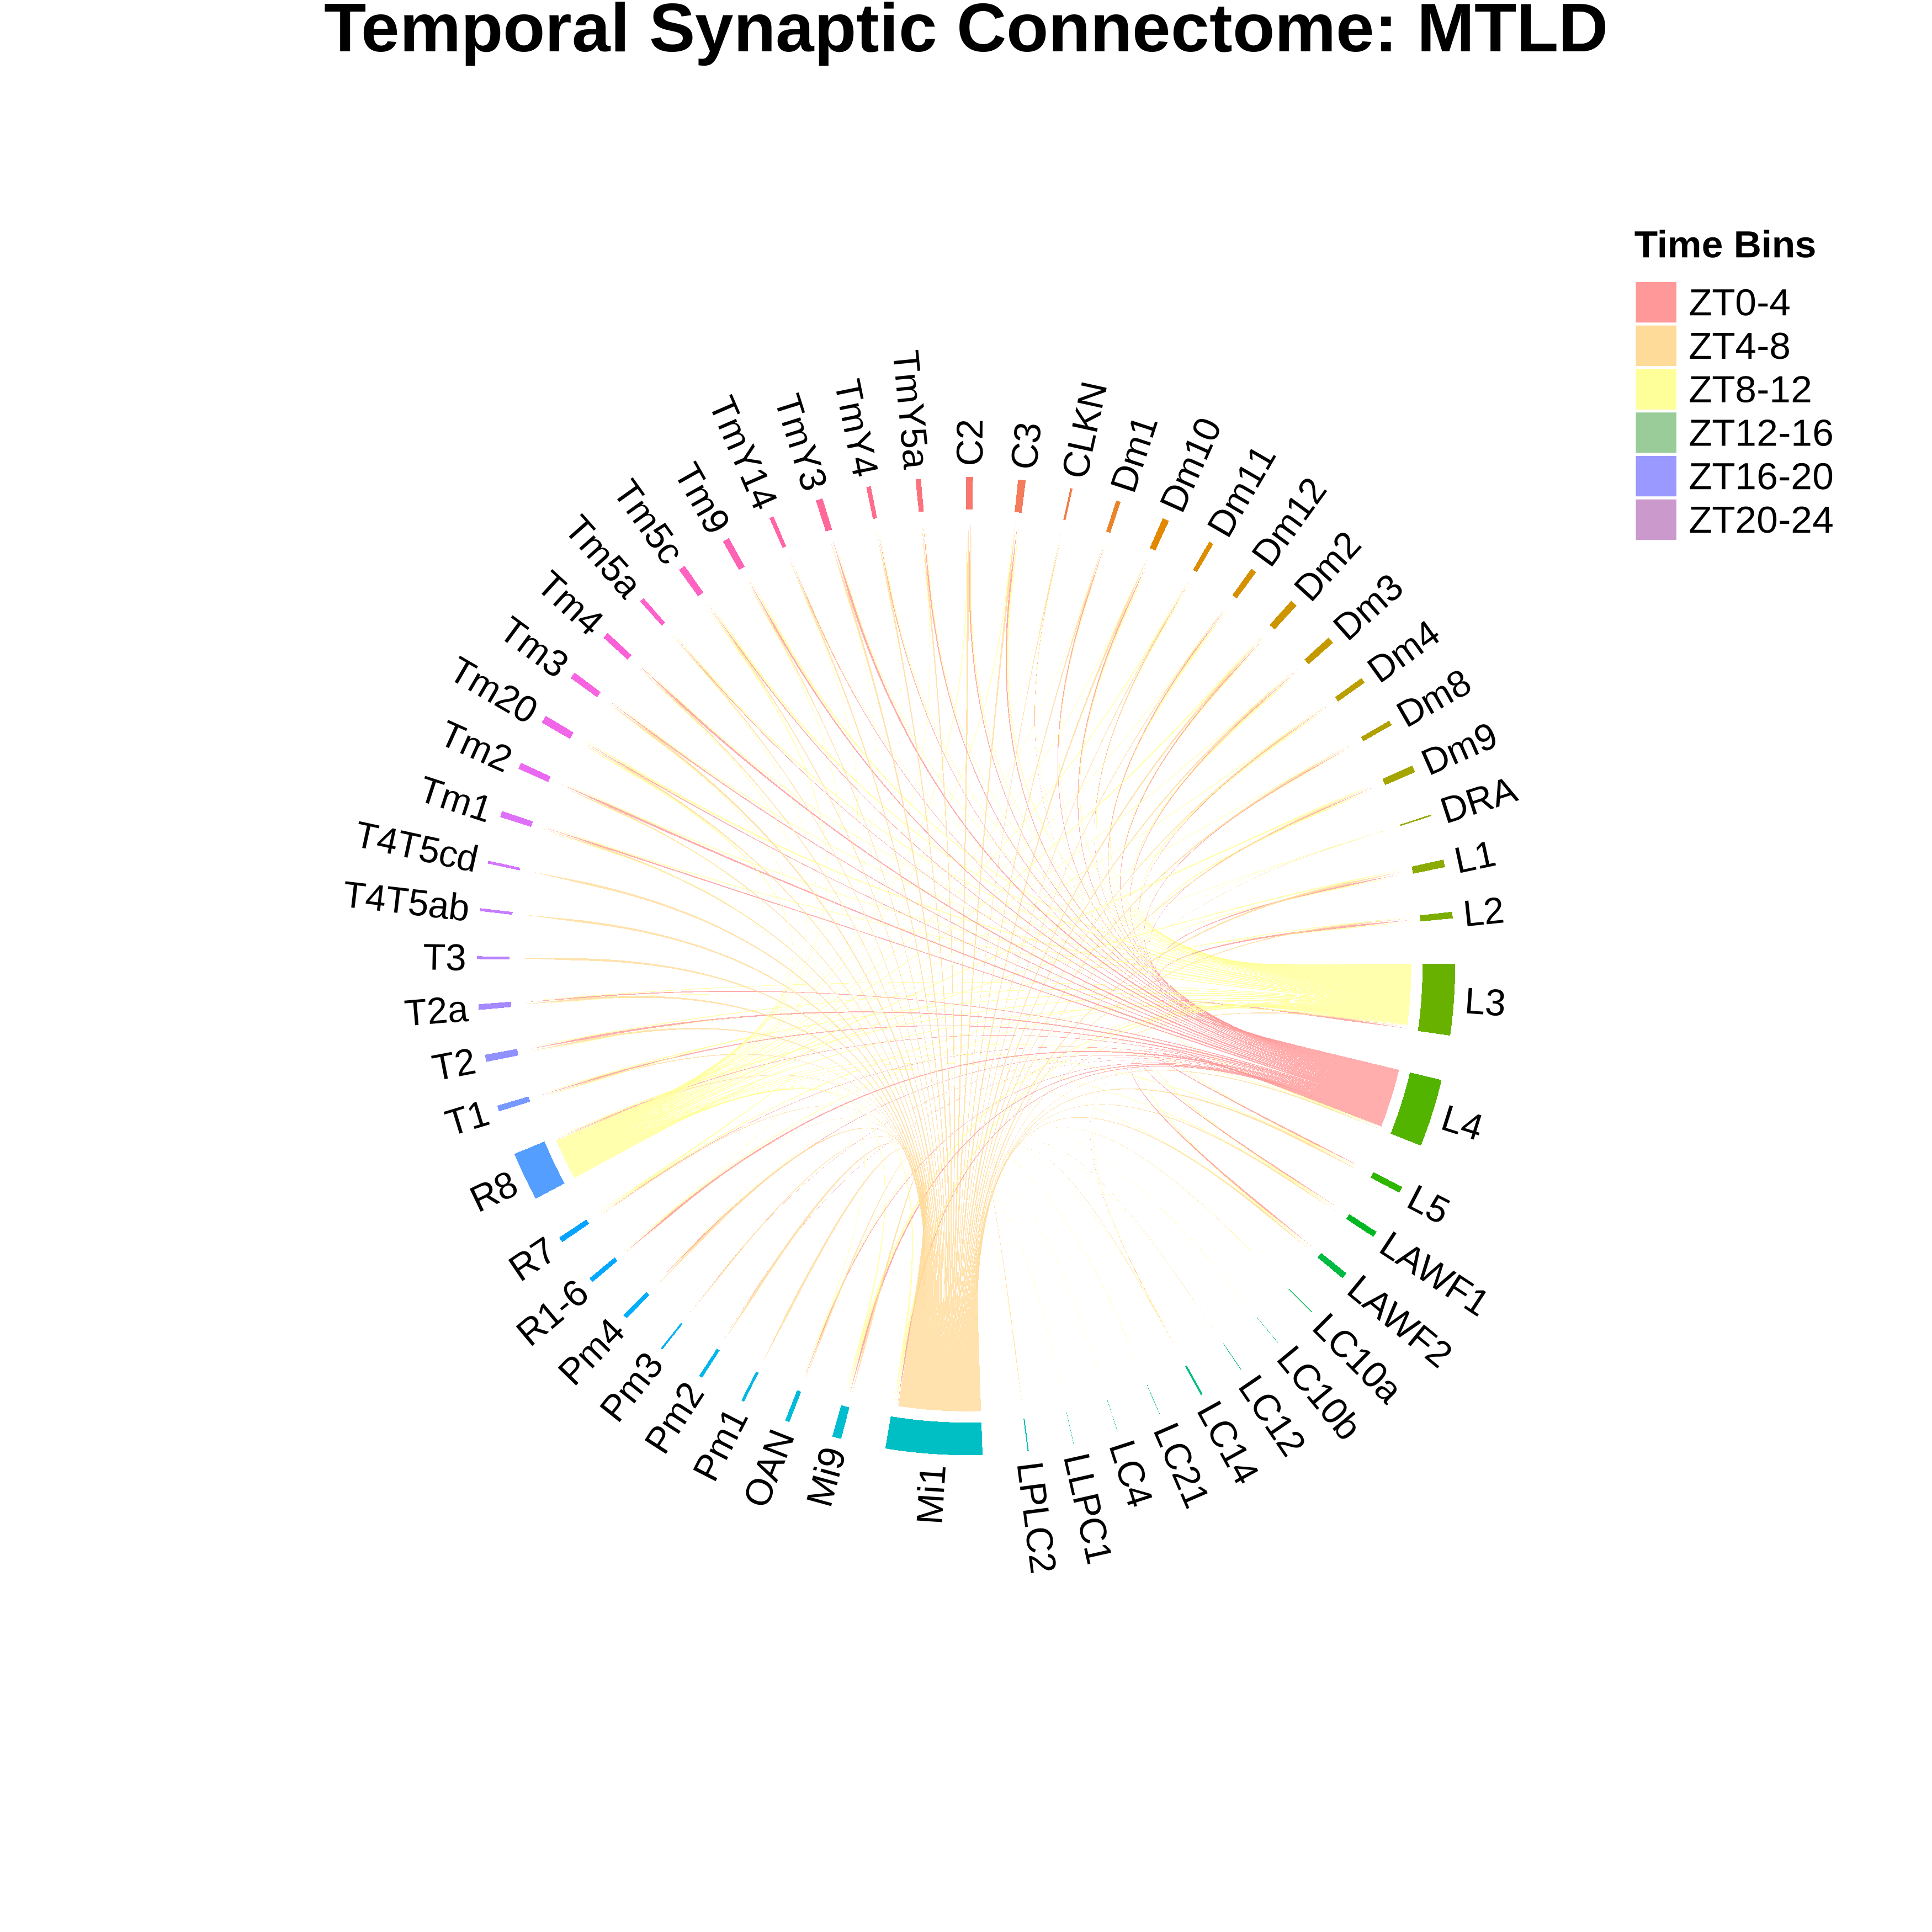

In [295]:
library(dplyr)
library(circlize)
library(RColorBrewer)
library(scales)
library(ComplexHeatmap)
library(grid)  # For unit()

# ------------------------------
# Filter out self-connections
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

par(bg = "white")

# Define time bin colors (must match Time_bin values)
time_block_colors <- c("ZT0-4" = "#ff9999", 
                       "ZT4-8" = "#ffdb99", 
                       "ZT8-12" = "#ffff99", 
                       "ZT12-16" = "#99cc99", 
                       "ZT16-20" = "#9999ff", 
                       "ZT20-24" = "#cc99cc")

# Plot one condition
cond <- "MTLD"

# Filter go_summary for current condition
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)

# Join GO term info to synapse table
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")

# Subset for current condition
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)

# Compute raw and communication score
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )

# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
current_cells <- length(unique(c(df_cond$pre_type, df_cond$post_type)))
current_avg <- total_interactions / current_cells
WTLD_avg <- 41284.74
G_min <- 1.5
alpha <- (7.49 - G_min) / log2(WTLD_avg / 1355.31)
ratio <- WTLD_avg / current_avg
dynamic_gap <- min(G_min + alpha * log2(ratio), 7.49)

# Print diagnostic info
cat("Condition:", cond, "\n")
cat("Total raw interactions:", total_interactions, "\n")
cat("Number of cell types:", current_cells, "\n")
cat("Average raw interactions per cell type:", round(current_avg, 2), "\n")
cat("Ratio (WTLD_avg/current_avg):", round(ratio, 2), "\n")
cat("Calculated dynamic gap:", round(dynamic_gap, 2), "\n")

# Assign colors to links (check for missing Time_bin)
df_cond <- df_cond %>%
  mutate(col = time_block_colors[Time_bin]) %>%
  mutate(col = ifelse(is.na(col), "#cccccc", col))  # fallback color

# Prepare for plotting
df_chord <- df_cond %>%
  rename(from = pre_type,
         to = post_type,
         value = Communication_score)

sector_names <- sort(unique(c(df_chord$from, df_chord$to)))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

# Safe link width computation
max_score <- max(df_chord$value, na.rm = TRUE)
df_chord <- df_chord %>%
  mutate(link_width = pmax(0.2, value / max_score * 5))  # ensure ≥ 0.2

# Optional manual override
dynamic_gap <- 5.3

# Plot settings
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)

# Draw the chord diagram
chordDiagram(
  x = df_chord[, c("from", "to", "value")],
  order = sector_names,
  grid.col = sector_colors,
  col = df_chord$col,
  directional = 1,
  direction.type = "arrows",
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$link_width,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.1)
)

# Add labels (suppress overflow warnings)
old_warn <- getOption("warn")
options(warn = -1)

circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

options(warn = old_warn)

# Add time bin legend
lgd_bins <- Legend(
  labels = names(time_block_colors),
  legend_gp = gpar(fill = time_block_colors),
  title = "Time Bins"
)
draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.8, "npc"))

# Add plot title
title(main = paste("Temporal Synaptic Connectome:", cond), cex.main = 1.5)


## MT DD

In [223]:
library(dplyr)
library(circlize)
library(RColorBrewer)
library(scales)
library(ComplexHeatmap)
library(grid)  # For unit()

# ------------------------------
# Filter out self-connections
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

par(bg = "white")

# Define time bin colors (must match Time_bin values)
time_block_colors <- c("CT0-4" = "#ff9999", 
                       "CT4-8" = "#ffdb99", 
                       "CT8-12" = "#ffff99", 
                       "CT12-16" = "#99cc99", 
                       "CT16-20" = "#9999ff", 
                       "CT20-24" = "#cc99cc")

# Plot one condition
cond <- "MTDD"

# Filter go_summary for current condition
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)

# Join GO term info to synapse table
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")

# Subset for current condition
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)

# Compute raw and communication score
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )

# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
current_cells <- length(unique(c(df_cond$pre_type, df_cond$post_type)))
current_avg <- total_interactions / current_cells
WTLD_avg <- 41284.74
G_min <- 1.5
alpha <- (7.49 - G_min) / log2(WTLD_avg / 1355.31)
ratio <- WTLD_avg / current_avg
dynamic_gap <- min(G_min + alpha * log2(ratio), 7.49)

# Print diagnostic info
cat("Condition:", cond, "\n")
cat("Total raw interactions:", total_interactions, "\n")
cat("Number of cell types:", current_cells, "\n")
cat("Average raw interactions per cell type:", round(current_avg, 2), "\n")
cat("Ratio (WTLD_avg/current_avg):", round(ratio, 2), "\n")
cat("Calculated dynamic gap:", round(dynamic_gap, 2), "\n")

# Assign colors to links (check for missing Time_bin)
df_cond <- df_cond %>%
  mutate(col = time_block_colors[Time_bin]) %>%
  mutate(col = ifelse(is.na(col), "#cccccc", col))  # fallback color

# Prepare for plotting
df_chord <- df_cond %>%
  rename(from = pre_type,
         to = post_type,
         value = Communication_score)

sector_names <- sort(unique(c(df_chord$from, df_chord$to)))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

# Safe link width computation
max_score <- max(df_chord$value, na.rm = TRUE)
df_chord <- df_chord %>%
  mutate(link_width = pmax(0.2, value / max_score * 5))  # ensure ≥ 0.2

# Optional manual override
dynamic_gap <- 0.2

# Plot settings
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)

# Draw the chord diagram
chordDiagram(
  x = df_chord[, c("from", "to", "value")],
  order = sector_names,
  grid.col = sector_colors,
  col = df_chord$col,
  directional = 1,
  direction.type = "arrows",
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$link_width,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.1)
)

# Add labels (suppress overflow warnings)
old_warn <- getOption("warn")
options(warn = -1)

circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

options(warn = old_warn)

# Add time bin legend
lgd_bins <- Legend(
  labels = names(time_block_colors),
  legend_gp = gpar(fill = time_block_colors),
  title = "Time Bins"
)
draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.8, "npc"))

# Add plot title
title(main = paste("Temporal Synaptic Connectome:", cond), cex.main = 1.5)


ERROR: Error: No data for condition: MTDD


In [31]:
library(dplyr)

# 1) Compute total outgoing synapses from CLKN
total_clkn_syn <- syn_agg %>% 
  filter(pre_type == "CLKN", pre_type != post_type) %>% 
  summarise(total_syn = sum(syn_count, na.rm = TRUE)) %>% 
  pull(total_syn)

# 2) For WTLD and WTDD, grab CLKN’s detected_terms and compute raw_score = total_syn * detected_terms
clkn_raw_scores <- go_summary %>% 
  filter(CellType == "CLKN", Condition %in% c("WTLD","WTDD")) %>% 
  # if CLKN is missing (e.g. WTLD), make detected_terms = 0
  complete(Condition = c("WTLD","WTDD"), fill = list(detected_terms = 0L)) %>% 
  mutate(
    total_syn_count = total_clkn_syn,
    raw_score       = total_syn_count * detected_terms
  ) %>% 
  select(Condition, detected_terms, total_syn_count, raw_score)

print(clkn_raw_scores)


ERROR: Error in complete(., Condition = c("WTLD", "WTDD"), fill = list(detected_terms = 0L)): could not find function "complete"


In [61]:
library(dplyr)

# Get all unique conditions from go_summary
all_conditions <- unique(go_summary$Condition)

# Initialize result table
clkn_scores_by_condition <- data.frame()

# Loop through each condition
for (cond in all_conditions) {
  
  # Subset GO terms to this condition
  go_cond <- go_summary %>%
    filter(Condition == cond)
  
  # ---- Incoming: other → CLKN ----
  incoming <- syn_agg %>%
    filter(post_type == "CLKN", pre_type != "CLKN") %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # ---- Outgoing: CLKN → other ----
  outgoing <- syn_agg %>%
    filter(pre_type == "CLKN", post_type != "CLKN") %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # ---- Summary for this condition ----
  summary_row <- data.frame(
    Condition        = cond,
    n_incoming_edges = nrow(incoming),
    sum_incoming     = sum(incoming$raw_score, na.rm = TRUE),
    n_outgoing_edges = nrow(outgoing),
    sum_outgoing     = sum(outgoing$raw_score, na.rm = TRUE),
    total_edges      = nrow(incoming) + nrow(outgoing),
    total_score      = sum(incoming$raw_score, na.rm = TRUE) + sum(outgoing$raw_score, na.rm = TRUE)
  )
  
  clkn_scores_by_condition <- bind_rows(clkn_scores_by_condition, summary_row)
}

# Print result
print(clkn_scores_by_condition)


Warning message in left_join(., go_cond, by = c(pre_type = "CellType")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 2 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


  Condition n_incoming_edges sum_incoming n_outgoing_edges sum_outgoing
1      WTLD               26         6340               48            0
2      MTLD               25           13               48            0
3      WTDD               24          106               96        13221
4      MTDD               24            6               48            0
  total_edges total_score
1          74        6340
2          73          13
3         120       13327
4          72           6


In [152]:
library(dplyr)

# Get all unique conditions from go_summary
all_conditions <- unique(go_summary$Condition)

# Initialize result table
clkn_scores_by_condition <- data.frame()

# Loop through each condition
for (cond in all_conditions) {
  
  # Subset GO terms to this condition
  go_cond <- go_summary %>%
    filter(Condition == cond)
  
  # ---- Incoming: other → CLKN ----
  incoming <- syn_agg %>%
    filter(post_type == "R1-6", pre_type != "R1-6") %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # ---- Outgoing: CLKN → other ----
  outgoing <- syn_agg %>%
    filter(pre_type == "R1-6", post_type != "R1-6") %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # ---- Summary for this condition ----
  summary_row <- data.frame(
    Condition        = cond,
    n_incoming_edges = nrow(incoming),
    sum_incoming     = sum(incoming$raw_score, na.rm = TRUE),
    n_outgoing_edges = nrow(outgoing),
    sum_outgoing     = sum(outgoing$raw_score, na.rm = TRUE),
    total_edges      = nrow(incoming) + nrow(outgoing),
    total_score      = sum(incoming$raw_score, na.rm = TRUE) + sum(outgoing$raw_score, na.rm = TRUE)
  )
  
  clkn_scores_by_condition <- bind_rows(clkn_scores_by_condition, summary_row)
}

# Print result
print(clkn_scores_by_condition)


Warning message in left_join(., go_cond, by = c(pre_type = "CellType")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 24 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


  Condition n_incoming_edges sum_incoming n_outgoing_edges sum_outgoing
1      MTLD               36        18646               42            0
2      WTLD               36         5693               84       314432
3      WTDD               36            2               42       786080
4      MTDD               36            0               42            0
  total_edges total_score
1          78       18646
2         120      320125
3          78      786082
4          78           0


In [297]:
library(dplyr)

# Define the finalized GO terms
final_go_terms <- c("GO:0007269"   # neurotransmitter secretion
                    ,"GO:0099536"   # synaptic signaling
                    ,"GO:0051588"  # regulation of neurotransmitter transport
                    ,"GO:0006836"  # neurotransmitter transport
                    ,"GO:0023061"  # synaptic vesicle priming 
                    ,"GO:0050808"  # synapse organization
                    ,"GO:0048167"  # regulation of synaptic plasticity
                    ,"GO:0099003"  # vesicle-mediated transport in synapse
                    #,"GO:0045202"  # (always off MT DD) synapse
                    ,"GO:0098960"  # postsynaptic neurotransmitter receptor activity  
                    ,"GO:0008088"  # axo-dendritic transport
                    #,"GO:0098793"  # (always off MT DD) presynapse
                    ,"GO:0098794"  # postsynapse
                    #,"GO:0034220" # monoatomic ion transmembrane transport 
                    #,"GO:0007218" # neuropeptide signaling pathway
                    #,"GO:0030658" #transport vesicle membrane 
                    #,"GO:0022804" #active transmembrane transporter activity
                    #,"GO:0097060" # (always off MT DD) synaptic membrane
                    #,"GO:0045211", # (always off MT DD) postsynaptic membrane
                    ,"GO:0098984" # neuron to neuron synapse
                    #,"GO:0099177" # regulation of trans-synaptic signaling
                    #,"GO:0030672" # synaptic vesicle membrane
                    #,"GO:0050806" # positive regulation of synaptic transmission
                    ,"GO:2000300" # regulation of synaptic vesicle exocytosis
                    #,"GO:0060078" #regulation of postsynaptic membrane potential
                    #,"GO:0099537" #trans-synaptic signaling 
                    #,"GO:0030594" #neurotransmitter receptor activity
                    #,"GO:0099565" #chemical synaptic transmission, postsynaptic
                    #,"GO:0060078" #"regulation of postsynaptic membrane potential
                   )
# Read the data
df_long <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/df_long_with_updated_clusters.csv")
df_long <- df_long[df_long$Set.N > 3,]

# Filter for rows containing one of the finalized GO terms
df_filtered <- df_long %>%
  filter(GO %in% final_go_terms)

# Bin the time point information from the "Value" column into 6 ranges:
# 0-4, 4-8, 8-12, 12-16, 16-20, and 20-24.
df_filtered <- df_filtered %>%
  mutate(Time_bin = cut(Value,
                        breaks = c(0, 4, 8, 12, 16, 20, 24),
                        labels = c("0-4", "4-8", "8-12", "12-16", "16-20", "20-24"),
                        right = FALSE,
                        include.lowest = TRUE))

# Bin the results by CellType, Condition, and Time_bin.
# Here we count the number of unique GO terms detected for each combination.
go_summary <- df_filtered %>%
  group_by(CellType, Condition, Time_bin) %>%
  summarize(detected_terms = n_distinct(GO),
            total_signals = n(),     # Total rows (if you want a raw count)
            .groups = "drop")

library(dplyr)

# Prepare final GO summary collapsed by CellType and Condition
go_collapsed <- go_summary %>%
  group_by(CellType, Condition) %>%
  summarise(detected_terms = sum(detected_terms, na.rm = TRUE), .groups = "drop")

# Initialize list to store per-condition summaries
clkn_summary_list <- list()

# Loop over each condition explicitly
for (cond in c("WTLD", "WTDD", "MTLD", "MTDD")) {
  
  # Filter GO terms and synapses relevant to this condition
  go_cond <- go_collapsed %>% filter(Condition == cond)
  syn_cond <- syn_agg %>%
    filter((pre_type == "Tm5a" | post_type == "Tm5a") & pre_type != post_type)
  
  # Join GO data for presynaptic cell
  syn_joined <- syn_cond %>%
    left_join(go_cond, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score = syn_count * detected_terms
    )
  
  # Summarize
  score_summary <- syn_joined %>%
    summarise(
      Condition = cond,
      total_raw = sum(raw_score, na.rm = TRUE),
      sum_log = sum(log10(raw_score + 1), na.rm = TRUE),
    )
  
  clkn_summary_list[[cond]] <- score_summary
}

# Combine results
clkn_summary <- bind_rows(clkn_summary_list)
print(clkn_summary)



  Condition total_raw    sum_log
1      WTLD     12430 110.489202
2      WTDD      6821  90.453064
3      MTLD      1844   8.416112
4      MTDD         0   0.000000


In [242]:
# Filter out self-connections
syn_agg_filtered <- syn_agg %>% 
  filter(pre_type != post_type)

par(bg = "white")

# Plot one condition
cond <- "WTLD"
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )
# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
cat("Total raw interactions:", total_interactions, "\n")

# Plot one condition
cond <- "WTDD"
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )
# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
cat("Total raw interactions:", total_interactions, "\n")


# Plot one condition
cond <- "WTDD"
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )
# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
cat("Total raw interactions:", total_interactions, "\n")


# Plot one condition
cond <- "MTDD"
go_sum_cond <- go_summary %>% 
  filter(Condition == cond)
df_temp <- syn_agg_filtered %>%
  left_join(go_sum_cond, by = c("pre_type" = "CellType"), relationship = "many-to-many")
df_cond <- df_temp %>% filter(Condition == cond)
if (nrow(df_cond) == 0) stop("No data for condition: ", cond)
df_cond <- df_cond %>%
  mutate(
    detected_terms = coalesce(detected_terms, 0L),
    raw_score = syn_count * detected_terms,
    Communication_score = log10(raw_score + 1)
  )
# Stats for adaptive gap
total_interactions <- sum(df_cond$raw_score, na.rm = TRUE)
cat("Total raw interactions:", total_interactions, "\n")

Total raw interactions: 1718376 
Total raw interactions: 1085404 
Total raw interactions: 1085404 


ERROR: Error: No data for condition: MTDD


In [247]:
library(dplyr)
library(tidyr)

get_raw_scores_by_condition <- function(cell_type) {
  # Incoming links → cell_type
  incoming <- syn_agg %>%
    filter(post_type == cell_type, pre_type != cell_type) %>%
    left_join(go_collapsed, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score      = syn_count * detected_terms
    ) %>%
    group_by(Condition) %>%
    summarise(
      raw_in = sum(raw_score, na.rm = TRUE),
      n_in   = n(),
      .groups = "drop"
    )

  # Outgoing links from cell_type →
  outgoing <- syn_agg %>%
    filter(pre_type == cell_type, post_type != cell_type) %>%
    left_join(go_collapsed, by = c("pre_type" = "CellType")) %>%
    mutate(
      detected_terms = coalesce(detected_terms, 0L),
      raw_score      = syn_count * detected_terms
    ) %>%
    group_by(Condition) %>%
    summarise(
      raw_out = sum(raw_score, na.rm = TRUE),
      n_out   = n(),
      .groups = "drop"
    )

  # Combine and fill missing with zeros
  full <- full_join(incoming, outgoing, by = "Condition") %>%
    replace_na(list(
      raw_in  = 0, n_in   = 0,
      raw_out = 0, n_out  = 0
    )) %>%
    mutate(
      total_raw = raw_in + raw_out
    )

  return(full)
}

# Example: get raw scores for CLKN
clkn_raw <- get_raw_scores_by_condition("Mi1")
print(clkn_raw)


# A tibble: 4 × 6
  Condition raw_in  n_in raw_out n_out total_raw
  <chr>      <int> <int>   <int> <int>     <int>
1 MTLD       24566     3 1142471    51   1167037
2 WTDD        5208     4       0     0      5208
3 WTLD       26418     9       0     0     26418
4 NA             0    36       0     0         0
